## <div align="center">Supraglacial lake detection with the AI-based Segment Anything Model (SAM)</div>

This tutorial demonstrates how the AI-based Segment Anything Model (SAM) ([Kirillov et al., 2023](http://arxiv.org/abs/2304.02643)) can be used on natural-color (RGB) imagery for ice/water surface classification and lake detection.

To fully automate lake detection without user interaction, the SAM processing utilizes the centroids of lake features as input, sometimes referred to as prompts. These centroids are determined using classic image segmentation methods, such as Otsu multi-thresholding and Connected Component Analysis (CCA) from both, natural color imagery and the **N**ormalized **D**ifference **W**ater **I**ndex modified for **ice** (NDWI<sub>ice</sub>). The required input (centroids or prompts) for this notebook can be created with the [Step 1 lake detection notebook](https://github.com/mstudinger/ATM-SfM-Bathymetry/blob/main/Jupyter/CAMBOTv2_lake_detection_using_NDWI_and_Otsu_thresholding.ipynb) available in this repository.   

This Jupyter notebook is using elements from the [Predictor Example tutorial](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb) from the [SAM GitHub repository](https://github.com/facebookresearch/segment-anything).

## Step 1: Getting started
The SAM Python™ module requires PyTorch and TorchVision. The SAM installation instructions recommend installing both packages with CUDA support, however, if that causes error messages the solution is often to install both packages without CUDA support.
* Recommended installation with CUDA support:  
`conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia`  
* Installation without CUDA support (CPU only):  
`conda install pytorch torchvision torchaudio cpuonly -c pytorch`  
* To install the SAM Python™ module use:  
`pip install git+https://github.com/facebookresearch/segment-anything.git`  

Verify that the installation was successful and check for CUDA support:

In [1]:
import torch
import torchvision
print("PyTorch version:    ", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:  ", torch.cuda.is_available())

PyTorch version:     2.3.0
Torchvision version: 0.18.0
CUDA is available:   False


In addition to installing the SAM Python™ module, a model check point needs to be downloaded to the computer you are using to run SAM. You can do this with:  
`!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth`   
or just use your webbrowser and the link above to copy the 2.4 GByte model file.

## Step 2: Import required packages and load needed input data

In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as fx

# determine which processing unit to use
if torch.cuda.is_available():
    processing_unit = "cuda" # use graphics processing unit (GPU)
else:    
    processing_unit = "cpu"  # use central processing unit (CPU)
    
# set file name for SAM model check point
sam_checkpoint = r".." + os.sep + "data" + os.sep + "SAM" + os.sep + "sam_vit_h_4b8939.pth"

# load image file for lake detection
f_name_img = r".." + os.sep + "data" + os.sep + "imagery" + os.sep + "IOCAM0_2019_GR_NASA_20190506-131614.4217.jpg"
image_bgr  = cv2.imread(f_name_img)                     # decoded color images have channels stored in B G R order
image      = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # re-arrange channels to R G B order needed for processing
img_size   = image.shape                                # needed for positioning labels in plots below

# load centroid locations stored as DataFrame in pickle file:
f_name_centroids = r".." + os.sep + "data" + os.sep + "imagery" + os.sep + "IOCAM0_2019_GR_NASA_20190506-131614.4217_lakes.pkl"
centroids = pd.read_pickle(f_name_centroids)

# extract location of centroid pixel of largest lake feature
indx_max = np.argmax(centroids['area_pixels']) # determine which lake feature is the biggest in terms of area
x_c = int(round(centroids['centroid_x'][indx_max]))
y_c = int(round(centroids['centroid_y'][indx_max]))
centroids

centroid_x   centroid_y  area_pixels  orientation  axis_major_length  \
0  1560.790360  2334.740873      4368327     0.399696        3716.901565   
1   216.141181  4552.394840       162529     0.676825         634.636152   
2  1536.980647  3774.115493       636283     0.470956        1691.278005   
3  2568.211079   268.090014       826715     0.163424        1824.945920   

   axis_minor_length  
0        1545.156544  
1         409.431562  
2         527.601752  
3         635.312723

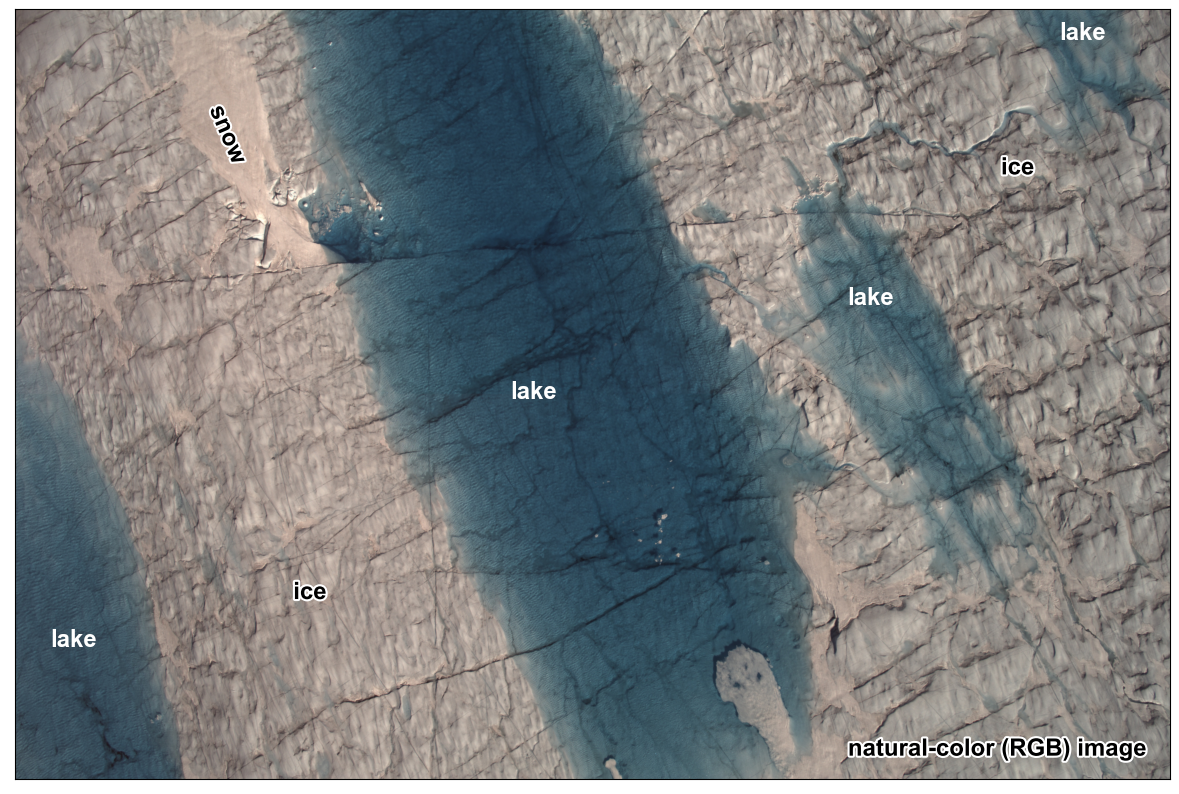

In [3]:
# plot RGB image
plt.rcParams['figure.figsize'] = [15, 10]
mpl.rcParams['font.size'] = 12

fig, (ax1)  = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle1_ax1 = ax1.imshow(image)
handle2_txt = ax1.text(1250,2500, "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle3_txt = ax1.text(4250,700,  "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle4_txt = ax1.text(2200,1650, "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle5_txt = ax1.text(250,2700,  "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle6_txt = ax1.text(3625,1250, "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle7_txt = ax1.text(4525,125,  "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle8_txt = ax1.text(900,650,   "snow",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

handle2_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle3_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle8_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle6_txt = ax1.text(img_size[1]-100,img_size[0]-100, "natural-color (RGB) image", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

## Step 3: Define helper functions for displaying results

In [4]:
# define helper functions for displaying results

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([  0/256, 197/256, 255/256, 0.3]) # RGB and aplha/transparency
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    #ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.plot(pos_points[:, 0], pos_points[:, 1],'o', markersize = 15,color = 'white', lw = 2, label='centroid',markerfacecolor = [255/256, 255/256,   0/256])    
    plt.plot(pos_points[:, 0], pos_points[:, 1],'o', markersize = 5,color = None, label='centroid',markerfacecolor = 'black') 
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    
    ax.plot(100,100,'o', markersize = 15,color = 'white', lw = 2, label='centroid',markerfacecolor = [255/256, 255/256,   0/256])    
    plt.plot(100,100,'o', markersize = 5,color = None, label='centroid',markerfacecolor = 'black') 
    handle2_ax1 = ax.text(2*100,100, "feature centroid from CCA", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'left', color = 'k', va="center")
    handle2_ax1.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
    handle6_txt = ax.text(img_size[1]-100,img_size[0]-100, r'Segment Anything Model (SAM) lake mask', fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
    handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

## Step 4: Lake detection with SAM

In [5]:
# load the SAM model and predictor
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

tic = time.perf_counter()
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=processing_unit)
predictor = SamPredictor(sam)

# process the image to produce an image embedding
predictor.set_image(image)
toc = time.perf_counter()
print(f"Time to create image embedding : {(toc - tic)/60:.1f} minutes")

# define prompt (use centroid location) from Connected Component Analysis (CCA)
input_point = np.array([[y_c, x_c]]) # CCA centroid. remember to flip x and y
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

print(f"Number of lake masks calculated: {masks.shape[0]:d}\n")

Time to create image embedding : 0.6 minutes
Number of lake masks calculated: 3



For the purpose of this tutorial choose the model's best mask and plot lake mask over RGB image:

Best mask: 1
Score: 0.994


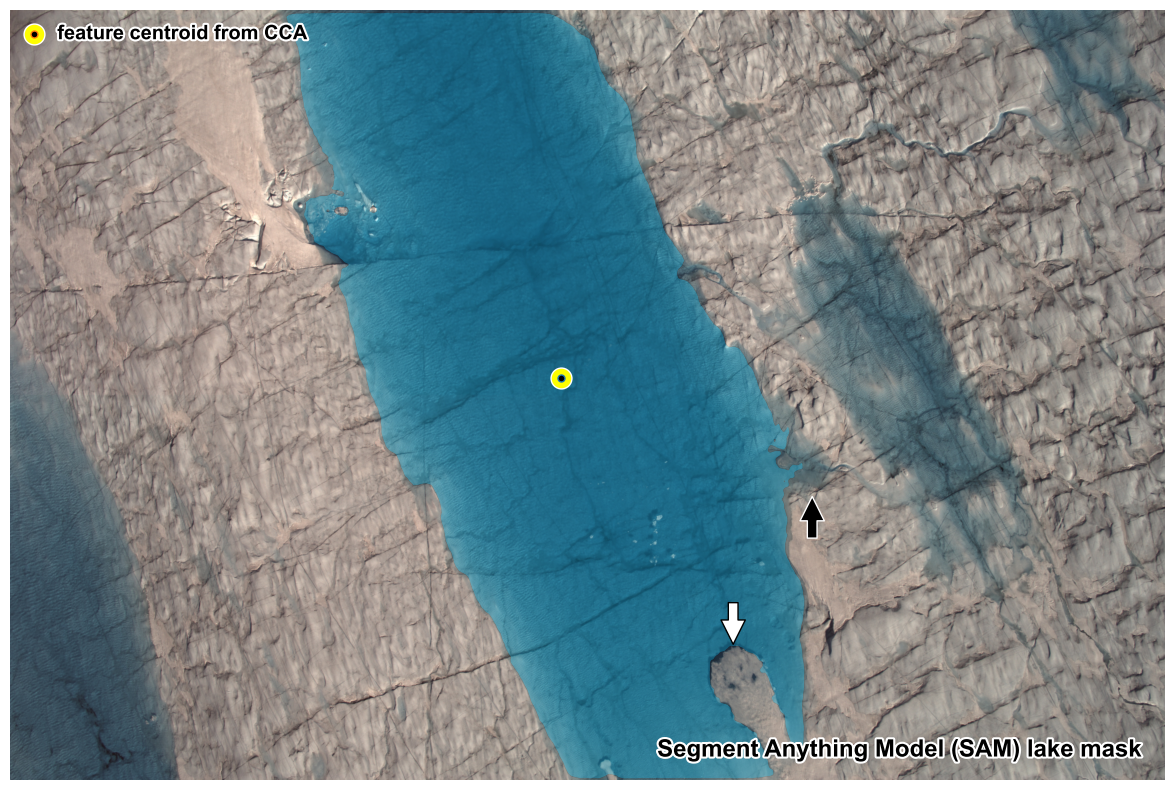

In [6]:
print(f"Best mask: {np.argmax(scores)+1}\nScore: {scores[np.argmax(scores)]:.3f}")

for i, (mask, score) in enumerate(zip(masks, scores)):
    if i == np.argmax(scores): # plot only the model's mask with the highest score. comment out to plot all available masks
        plt.figure(figsize=(15,10)) # create a new figure if multiple masks are plotted
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.annotate('', xy=(3065,2500+200 ),  xycoords='data', size = 35, font = 'Arial',fontweight = 'bold',
            xytext=(3065,2500 ), textcoords='data', color = 'w',ha = 'right', va = 'top',
            arrowprops=dict(arrowstyle="simple",color = 'w', ec = 'k',fc='w',lw = 1.0))
        plt.annotate('', xy=(3400,2250-200 ),  xycoords='data', size = 35, font = 'Arial',fontweight = 'bold',
            xytext=(3400,2250 ), textcoords='data', color = 'k',ha = 'right', va = 'top',
            arrowprops=dict(arrowstyle="simple",color = 'w', ec = 'w',fc='k',lw = 1.0))
        plt.show()

The preliminary lake masks calculated using SAM show difficulties tracking shallow water depths near the shorelines (marked by the black arrow) compared to the NDWI<sub>ice</sub> threshold approach. The small ice floe marked by the white arrow is correctly classified as snow/ice.  

Now add the centroid locations of the 4 largest lakes as prompts for the model:

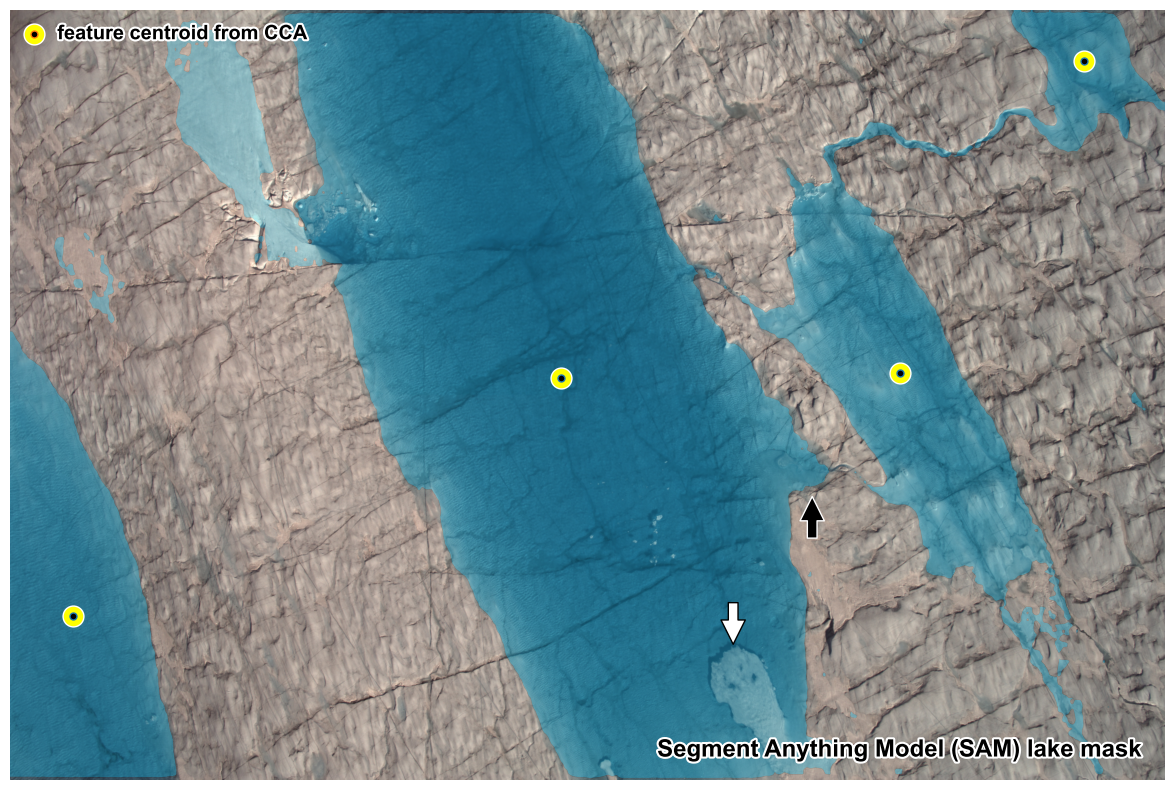

In [7]:
# extract location of centroid pixels of 4 largest lake features -- needs to be improved
x0 = int(round(centroids['centroid_x'][0]))
y0 = int(round(centroids['centroid_y'][0]))
x1 = int(round(centroids['centroid_x'][1]))
y1 = int(round(centroids['centroid_y'][1]))
x2 = int(round(centroids['centroid_x'][2]))
y2 = int(round(centroids['centroid_y'][2]))
x3 = int(round(centroids['centroid_x'][3]))
y3 = int(round(centroids['centroid_y'][3]))

# also needs to be streamlined in future updates
input_point = np.array([[y0, x0], [y1, x1], [y2,x2],[y3,x3]])
input_label = np.array([1,1,1,1])

mask_input = logits[np.argmax(scores), :, :]  # choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(15,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.annotate('', xy=(3065,2500+200 ),  xycoords='data', size = 35, font = 'Arial',fontweight = 'bold',
    xytext=(3065,2500 ), textcoords='data', color = 'w',ha = 'right', va = 'top',
    arrowprops=dict(arrowstyle="simple",color = 'w', ec = 'k',fc='w',lw = 1.0))
plt.annotate('', xy=(3400,2250-200 ),  xycoords='data', size = 35, font = 'Arial',fontweight = 'bold',
    xytext=(3400,2250 ), textcoords='data', color = 'k',ha = 'right', va = 'top',
    arrowprops=dict(arrowstyle="simple",color = 'w', ec = 'w',fc='k',lw = 1.0))
plt.show() 

Now, the small, shallow embayment that was missed in the previous run is detected (black arrow), but the ice floe (marked by the white arrow) and parts of the snow patches are falsely classified as water. **Future work will focus on improving tracking of these problematic areas.**    

**References**
* Kirillov, A. et al., Segment Anything, arXiv, http://arxiv.org/abs/2304.02643, 2023.
* Liao, P-S., Chen, T-S. and Chung, P-C., A fast algorithm for multilevel thresholding, Journal of Information Science and Engineering 17 (5): 713-727, https://doi.org/10.6688/JISE.2001.17.5.1, 2001.
* Otsu, N.: A Threshold Selection Method from Gray-Level Histograms, IEEE Trans. Syst., Man, Cybern., 9, 62–66, https://doi.org/10.1109/TSMC.1979.4310076, 1979.